In [1]:
from datasets import get_dataset
from plots import plot_survival_individual, plot_survival_grouped

import matplotlib.pyplot as plt
import pandas as pd
from synthcity.plugins.models.time_to_event.loader import get_model_template
from synthcity.plugins import Plugins
from synthcity.utils.serialization import save_to_file, load_from_file
from pathlib import Path

In [2]:
out_dir = Path("output")


def plot_dataset_perf_baselines(
    dataset: str, ci_show: bool = True, ci_alpha: float = 0.2, **kwargs,
):
    df, duration_col, event_col, time_horizons = get_dataset(dataset)

    scenario = "imbalanced_sampler"

    Xcov = df.drop(columns=[duration_col, event_col])
    T = df[duration_col]
    E = df[event_col]

    preds = []
    for dataloader_sampling_strategy in [
        "none",
        "imbalanced_censoring",
        "imbalanced_time_censoring",
    ]:
        model_bkp_10x = (
            out_dir
            / f"experiment_{scenario}_{dataset}_{dataloader_sampling_strategy}.10x"
        )
        model_bkp_1x = (
            out_dir / f"experiment_{scenario}_{dataset}_{dataloader_sampling_strategy}"
        )

        print("eval ", model_bkp_10x)
        label = f"sampling strategy: {dataloader_sampling_strategy}"

        syn_df_10x = None
        syn_df_1x = None

        if model_bkp_10x.exists():
            syn_df_10x = load_from_file(model_bkp_10x)
        if model_bkp_1x.exists():
            syn_df_1x = load_from_file(model_bkp_1x)

        if syn_df_10x is None or syn_df_1x is None:
            syn_model = Plugins().get(
                "survival_gan",
                dataloader_sampling_strategy=dataloader_sampling_strategy,
            )

            try:
                syn_model.fit(df)

                syn_df_10x = syn_model.generate(10 * len(df))
                syn_df_1x = syn_model.generate(len(df))
            except BaseException as e:
                print("plugin failed", e)
                continue

            save_to_file(model_bkp_10x, syn_df_10x)
            save_to_file(model_bkp_1x, syn_df_1x)

        syn_T = syn_df_10x[duration_col]
        syn_E = syn_df_10x[event_col]

        local_data = (label, syn_T, syn_E)

        plot_survival_individual(
            scenario,
            dataset,
            label,
            T,
            E,
            [local_data],
            ci_show=ci_show,
            ci_alpha=ci_alpha,
        )
        preds.append(local_data)

    plot_survival_grouped(
        scenario, dataset, T, E, preds, ci_show=ci_show, ci_alpha=ci_alpha
    )

## AIDS

eval  output/experiment_imbalanced_sampler_aids_none.10x


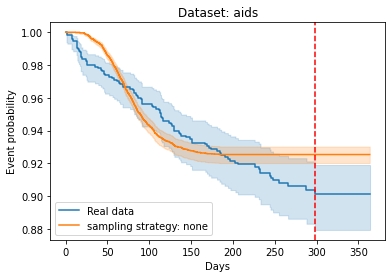

eval  output/experiment_imbalanced_sampler_aids_imbalanced_censoring.10x


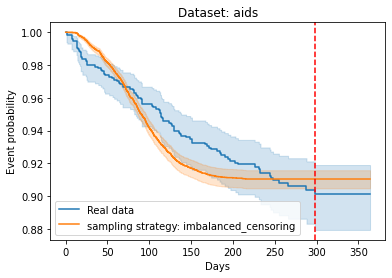

eval  output/experiment_imbalanced_sampler_aids_imbalanced_time_censoring.10x


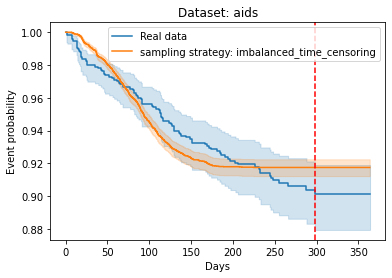

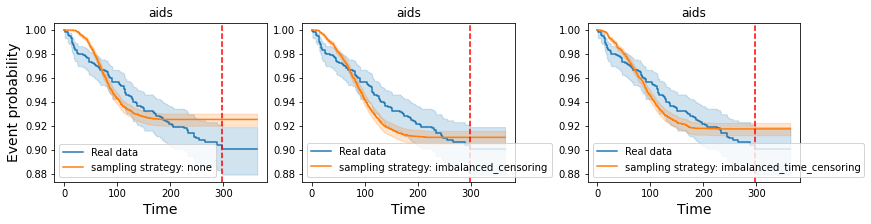

In [3]:
plot_dataset_perf_baselines("aids",)

## CUTRACT

In [ ]:
plot_dataset_perf_baselines("cutract",)

eval  output/experiment_imbalanced_sampler_cutract_none.10x


## MAGGIC

In [ ]:
plot_dataset_perf_baselines("maggic",)

## METABRIC

In [ ]:
plot_dataset_perf_baselines("metabric",)

## SEER

In [ ]:
plot_dataset_perf_baselines(
    "survival_function", "seer", models=baseline_models,
)